**Author:** Shahed Sabab  
**Tech Stack:** LangGraph 

---

# Data Analyst

## Summary

This notebook demonstrates the implementation of a multi-agent network designed for data analysis tasks using LangGraph. The system leverages specialized agents to handle different aspects of the data analysis process, ensuring efficient and comprehensive responses to user inquiries.

The system utilizes the key components of LangGraph:

1. **Nodes**: Represent different steps in the data analysis process.
2. **Edges**: Define transitions between nodes, which can be conditional.
3. **Agents**: Perform specific tasks within nodes.
4. **State**: Maintains shared information across the network.

The system comprises three key agents:

1. **Supervisor**: Acts as the main coordinator, receiving and breaking down user queries.
2. **Researcher**: Utilizes search tools to find relevant information for queries.
3. **Coder**: Creates visualizations and plots based on analyzed data.

Each agent has specific roles, goals, and capabilities, working collaboratively to achieve the overall objective of providing insightful data analysis and visualization.

---

<div style="text-align: center;">
    <img src="figure/data_analyst_agent.png" alt="data analyst agent diagram" width="1200"/>
</div>

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.tools import tool

In [3]:
from dotenv import load_dotenv
import os
# from swarms import GPT4VisionAPI

# Load environment variables
load_dotenv()

# Initialize GPT-4 Omni API
api_key = os.getenv("OPENAI_API_KEY")

In [4]:
tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

# Helper

In [13]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
    return executor

In [15]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

# Supervisor

In [18]:

from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

# Construct graph

In [41]:

import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher. Do not foget to refer the source")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [43]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="Based on the gathered resources, here is the population data for Canadian provinces in 2022 and 2016:\n\n### Population of Canadian Provinces in 2022 (in Millions)\n1. **Ontario**: 15.07\n2. **Quebec**: 8.64\n3. **British Columbia**: 5.28\n4. **Alberta**: 4.54\n5. **Manitoba**: 1.39\n6. **Saskatchewan**: 1.19\n7. **Nova Scotia**: 1.00\n8. **New Brunswick**: 0.78\n9. **Newfoundland and Labrador**: 0.52\n10. **Prince Edward Island**: 0.17\n\nSource: [Statistics Canada, 2022](https://www150.statcan.gc.ca/n1/pub/91-215-x/91-215-x2022001-eng.htm)\n\n### Population of Canadian Provinces in 2016 (in Millions)\n1. **Ontario**: 13.45\n2. **Quebec**: 8.16\n3. **British Columbia**: 4.65\n4. **Alberta**: 4.07\n5. **Manitoba**: 1.28\n6. **Saskatchewan**: 1.10\n7. **Nova Scotia**: 0.92\n8. **New Brunswick**: 0.75\n9. **Newfoundland and Labrador**: 0.52\n10. **Prince Edward Island**: 0.15\n\nSource: [Statis

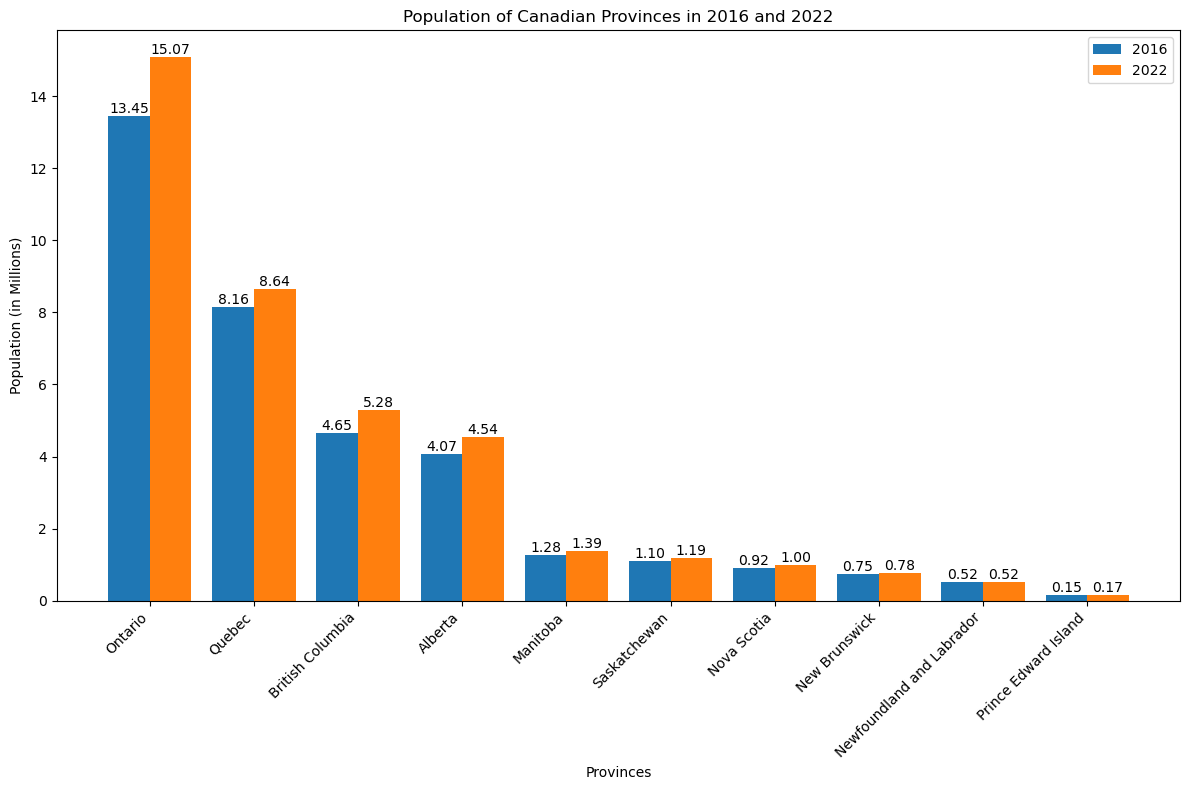

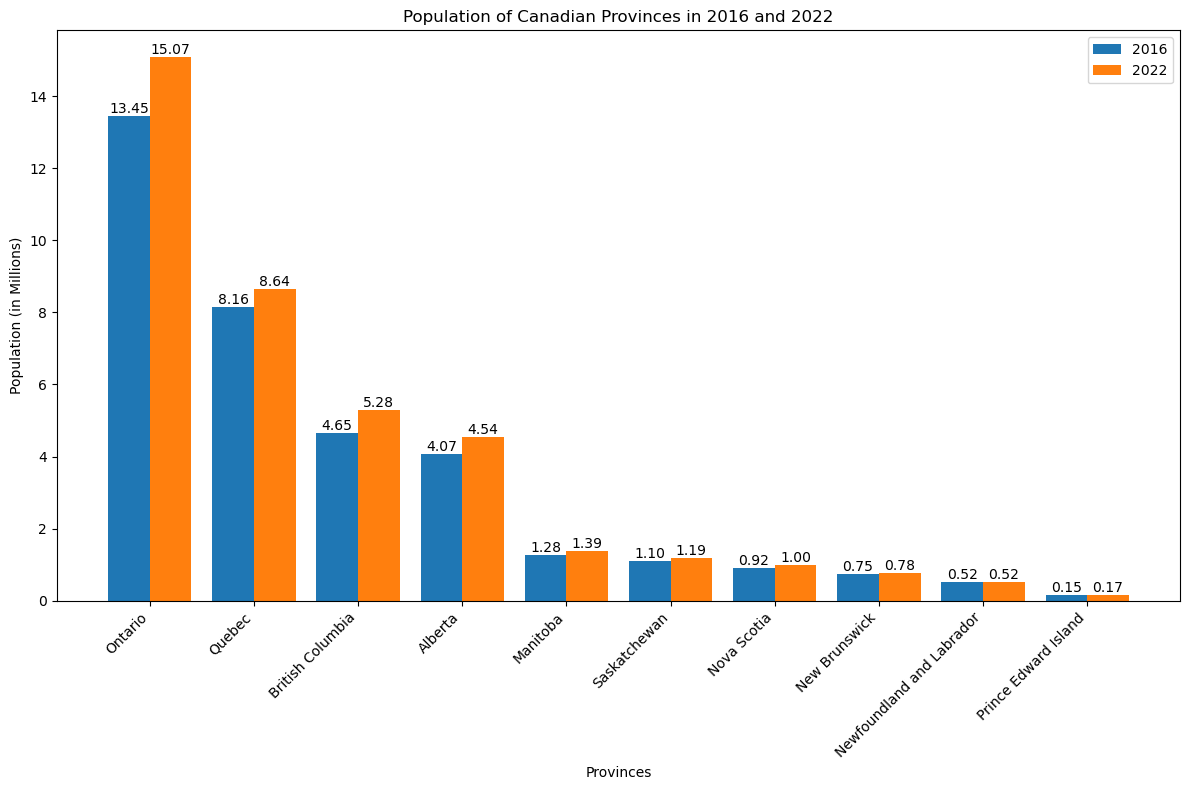

{'Coder': {'messages': [HumanMessage(content="Here is the bar plot visualizing the population of Canadian provinces in 2016 and 2022. Each bar's height represents the population of each province in millions, with a comparison between the years 2022 and 2016. The numbers on top of each bar indicate the exact population figures for better clarity.", name='Coder')]}}
----
{'supervisor': {'next': 'Coder'}}
----


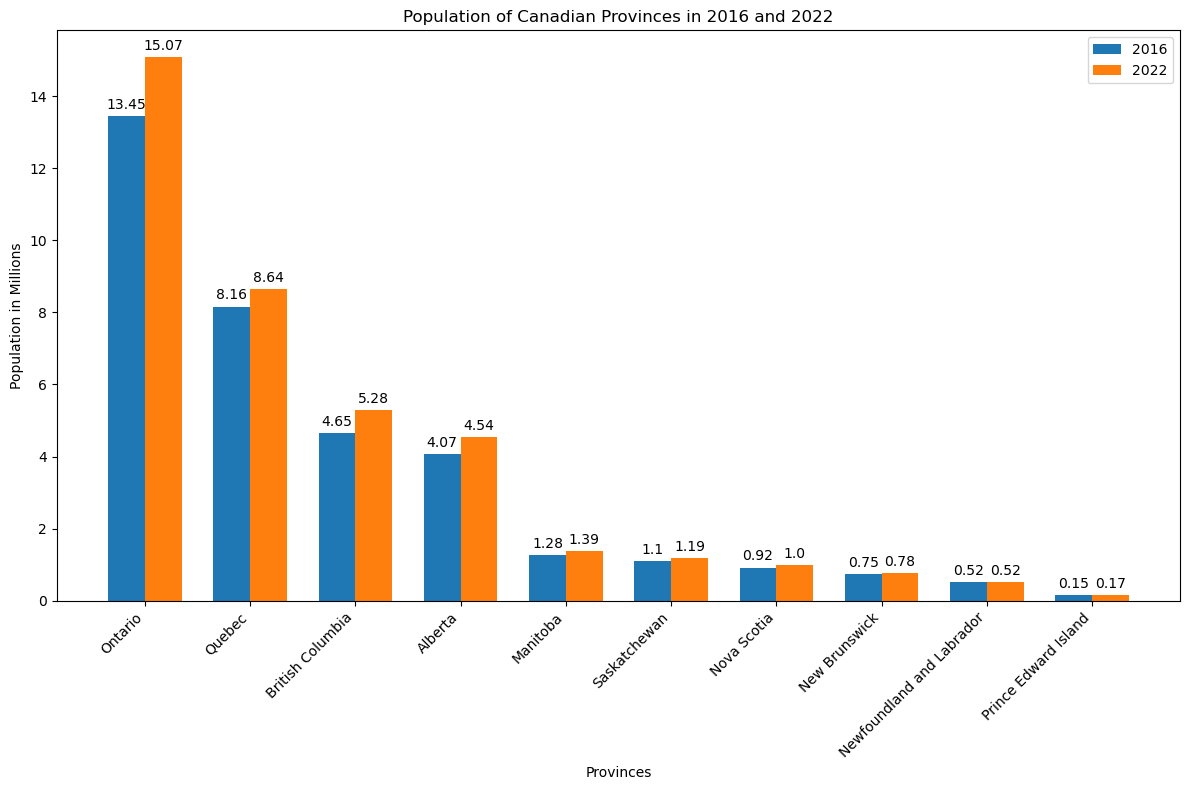

{'Coder': {'messages': [HumanMessage(content="Here is the bar plot visualizing the population of Canadian provinces in 2016 and 2022. Each bar's height represents the population of each province in millions, with a comparison between the years 2022 and 2016. The numbers on top of each bar indicate the exact population figures for better clarity.\n\n![Population Bar Plot](sandbox:/mnt/data/population_bar_plot.png)", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [55]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Population bar plot of canadian provinces in Millions in 2022. Contrast that with 2016. State the number for each bar")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")